Initial generation: Molecule: CC(=O)Nc1ccc(cc1)-c1cnc(C)c(Nc2cc(C(=O)N3CCOCC3)ccn2)c1
 | Binding affinity: -10.52
Iteration 1: Molecule: CC(=O)Nc1ccc(cc1)-c1cnc(C)c(Nc2cc(C(=O)N3CCOCC3)c(F)cn2)c1
 | Binding affinity: -10.25
Iteration 2: Molecule: CC(=O)Nc1ccc(cc1)-c1cnc(C)c(Nc2cc(C(=O)N3CCOCC3)c(Cl)cn2)c1
 | Binding affinity: -10.82
Iteration 3: Molecule: CC(=O)Nc1ccc(cc1)-c1cnc(C)c(Nc2cc(C(=O)N3CCCC3)c(Cl)cn2)c1
 | Binding affinity: -10.7
Iteration 4: Molecule: CC(=O)Nc1ccc(cc1)-c1cnc(C)c(Nc2cc(C(=O)N3CCCCC3)c(Cl)cn2)c1
 | Binding affinity: -11.18
Iteration 5: Molecule: CC(=O)Nc1ccc(cc1)-c1cnc(C)c(Nc2cc(C(=O)N3CCCCCC3)c(Cl)cn2)c1
 | Binding affinity: -11.26
Iteration 6: Molecule: CC(=O)Nc1ccc(cc1)-c1cnc(C)c(Nc2cc(C(=O)N3CCN(C)CC3)c(Cl)cn2)c1
 | Binding affinity: -10.7
Iteration 7: Molecule: CC(=O)Nc1ccc(cc1)-c1cnc(C)c(Nc2cc(C(=O)N3CCOCC3)c(Br)cn2)c1
 | Binding affinity: -10.92
Iteration 8: Molecule: CC(=O)Nc1ccc(cc1)-c1cnc(C)c(Nc2cc(C(=O)N3CCCCC3)c(Br)cn2)c1
 | Binding affinity: -11.2

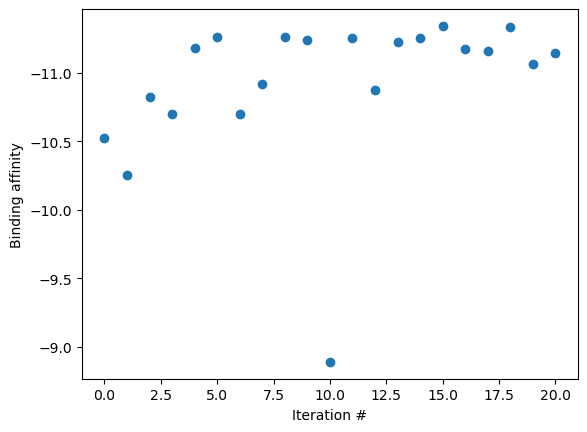

In [2]:
from google import genai
from google.genai import types
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

from api import calculate_affinity

load_dotenv()

protein = "brd4"

system_instructions = "You are an assistant helping a lab generate ligands that can bind to certain proteins with high binding affinity."
client = genai.Client(api_key=os.environ["API_KEY"])
chat = client.chats.create(model="gemini-2.0-flash", config=types.GenerateContentConfig(system_instruction=system_instructions))

init_prompt = f"Generate a ligand that can bind to {protein} with high binding affinity. Provide only your final answer in SMILES encoding format, and make sure that the SMILES string is valid."
response = chat.send_message(init_prompt)
ligand = response.text

affinity = calculate_affinity(ligand, protein)
print(f"Initial generation: Molecule: {ligand} | Binding affinity: {affinity}")

num_iterations = 20
affinities = [affinity]
best_affinity = affinity
best_molecule = ligand
best_iteration = 0
for i in range(num_iterations):
    iterated_prompt = f"Software shows that the molecule you generated ({ligand}) has a binding affinity of {affinity} to {protein}. Based on this information, generate a better ligand, following the same answer format"
    response = chat.send_message(iterated_prompt)
    ligand = response.text

    affinity = calculate_affinity(ligand, protein)
    affinities.append(affinity)
    if affinity<best_affinity:
        best_affinity = affinity
        best_molecule = ligand
        best_iteration = i+1
    print(f"Iteration {i+1}: Molecule: {ligand} | Binding affinity: {affinity}")

print(f"Best ligand: {best_molecule} with binding affinity {best_affinity} at iteration {best_iteration}")
scatter = plt.scatter(range(0, num_iterations+1), affinities)
plt.xlabel("Iteration #")
plt.ylabel("Binding affinity")
ax = scatter.axes
ax.invert_yaxis()
plt.show()

